In [9]:
#Import statements
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Attention, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import en_core_web_sm
import string
import re

import nltk
from nltk.util import ngrams
nltk.download('vader_lexicon')
nltk.download('stopwords')
stop_words=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Read the text data
with open('/kaggle/input/nlp-specialization-data/Novel - Moby-Dick By Herman Melville.txt', 'r', encoding='utf-8') as file:
    df = file.read()

In [11]:
#Calculate basic statistics
words = df.split()
total_words = len(words)
unique_words = len(set(words))
avg_word_length = sum(len(word) for word in words) / total_words

print(f"Total words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Average word length: {avg_word_length}")

Total words: 208425
Unique words: 32549
Average word length: 4.7091807604653955


In [12]:
#Analyze the frequency distribution of words in the text
from collections import Counter
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)

print("Top 10 most common words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Top 10 most common words:
the: 13411
of: 6364
and: 5803
a: 4393
to: 4368
in: 3751
that: 2641
his: 2385
I: 1714
with: 1617


In [13]:
#Analyze sentence length statistics to understand the distribution of sentence lengths
sentences = df.split('\n')
sentence_lengths = [len(sentence.split()) for sentence in sentences]

max_sentence_length = max(sentence_lengths)
min_sentence_length = min(sentence_lengths)
avg_sentence_length = sum(sentence_lengths) / len(sentences)

print(f"Max sentence length: {max_sentence_length}")
print(f"Min sentence length: {min_sentence_length}")
print(f"Average sentence length: {avg_sentence_length}")

Max sentence length: 18
Min sentence length: 0
Average sentence length: 9.294728861933642


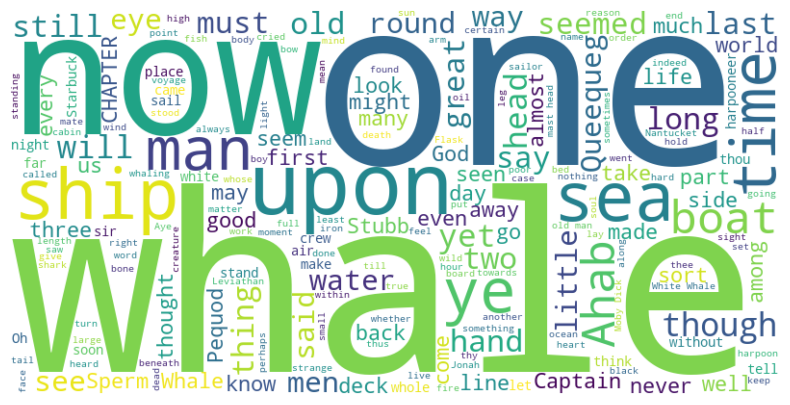

In [14]:
#Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [16]:
def clean_text(text):
    text= "".join ([word.lower() for word in text if word not in string.punctuation])
    tokens= re.split('\W+',text)
    text= [word for word in tokens if word not in stop_words]
#     text = str(text)
    return text

clean_data = clean_text(df)
clean_data[:10]

['chapter',
 '1',
 'loomings',
 'call',
 'ishmael',
 'years',
 'agonever',
 'mind',
 'long',
 'preciselyhaving']

In [17]:
nlp = en_core_web_sm.load()
nlp.max_length = 1198623
tokens = separate_punc(df)

In [18]:
# Context window and overlap
context_window_size = 25
overlap = 5  # Adjust this value as needed

# Empty list of sequences
text_sequences = []

for i in range(0, len(tokens) - context_window_size + 1, context_window_size - overlap):
    # Grab a sequence of tokens
    seq = tokens[i:i + context_window_size]
    
    # Add to list of sequences
    text_sequences.append(seq)

In [19]:
#Tokenizing
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [20]:
#Converting to array
sequences = np.array(sequences)

In [21]:
total_word = len(tokenizer.word_index) + 1
print(total_word)

17528


In [22]:
#Declaring x and y
x, labels = sequences[:,:-1],sequences[:,-1]
y= tf.keras.utils.to_categorical(labels, num_classes = total_word)

In [23]:
#Declaring vocab size
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

17526

In [24]:
max_sequence_len = max([len(x) for x in sequences])
print(max_sequence_len)

25


In [27]:
#Model architecture
model = Sequential()
model.add(Embedding(total_word, 100, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_word, activation = 'softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [28]:
#Training the model for 20 epochs
model.fit(x, y, epochs=20, verbose = 1)

Epoch 1/20
336/336 [==============================] - 23s 52ms/step - loss: 7.5683 - accuracy: 0.0644
Epoch 2/20
336/336 [==============================] - 6s 17ms/step - loss: 6.2341 - accuracy: 0.0818
Epoch 3/20
336/336 [==============================] - 4s 13ms/step - loss: 5.1080 - accuracy: 0.1269
Epoch 4/20
336/336 [==============================] - 5s 14ms/step - loss: 3.4962 - accuracy: 0.2918
Epoch 5/20
336/336 [==============================] - 4s 12ms/step - loss: 1.8241 - accuracy: 0.5848
Epoch 6/20
336/336 [==============================] - 5s 13ms/step - loss: 0.7766 - accuracy: 0.8159
Epoch 7/20
336/336 [==============================] - 4s 12ms/step - loss: 0.2799 - accuracy: 0.9394
Epoch 8/20
336/336 [==============================] - 4s 12ms/step - loss: 0.0800 - accuracy: 0.9879
Epoch 9/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0144 - accuracy: 0.9995
Epoch 10/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0032 - accur

In [30]:
#Generating text using the model
seed_text = "The sea was calm and the sky was clear"
next_words = 10  # Adjust the number of predicted next words

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)[0]
    # Find the index with the highest probability (predicted word index)
    predicted_index = np.argmax(predicted_probabilities)
    # Map the predicted index to the corresponding word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

The sea was calm and the sky was clear of his foot of him down the soul him in


The words and phrases may be structured properly in terms of language rules, but they do not form a logically meaningful or contextually relevant sentence. The predicted output is grammatically correct but not semantically correct